# Deep Vision Project by Fabian Schmidt
####  Who is allowed to enter the classroom: Contrastive Learning for face and signature recognition

<a id="0"></a>
 # Table of Contents
1. [Preparing the Dataset](#1)     
    - [Download Datasets](#1a)
    - [Define Custom Dataset class](#1b)
    - [Define Train-Test-Split](#1c)
    - [Print positive and negative Sample](#1d)
2. [Define Model](#2)


## Preparing the Dataset<a class="anchor" id="1"></a>

#### Download Face and signature-verification Dataset<a class="anchor" id="1a">

In [ ]:
import opendatasets as od 
import pandas 

od.download('https://www.kaggle.com/datasets/kasikrit/att-database-of-faces/data')
!mv att-database-of-faces faces
!mv faces data/faces
  


In [ ]:
od.download("https://www.kaggle.com/datasets/mallapraveen/signature-matching/data") 
!mv signature-matching/custom signature
!rmdir signature-matching/
!mv signature data

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image
import PIL.Image 

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.utils
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

# Showing images
def imshow(img, text=None):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
        
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

# Plotting data
def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

#### Define Custom Dataset classes<a class="anchor" id="1b">

##### ForgeryDataset

In [2]:
import pandas as pd
import os
import PIL
class ForgeryDataset(Dataset):
    def __init__(self, df, root_dir, transform=None):        
        self.transform = transform
        self.root_dir = root_dir
        self.data = df

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img0_name = os.path.join(self.root_dir, self.data.iloc[idx, 0])
        img1_name = os.path.join(self.root_dir, self.data.iloc[idx, 1])
        image0 = Image.open(img0_name)
        image1 = Image.open(img1_name)
        
        image0 = image0.convert("L")
        image1 = image1.convert("L")

        if self.transform:
            image0 = self.transform(image0)
            image1 = self.transform(image1)

        return image0, image1, torch.from_numpy(np.array([int(self.data.iloc[idx, 2])], dtype=np.float32))
        
    def __len__(self):
        return len(self.data)

In [3]:
from sklearn.model_selection import train_test_split
from PIL import Image, ImageOps, ImageFilter
# Load the training dataset
folder_dataset = datasets.ImageFolder(root="./data/faces/")

forgery_train_csv = "./data/signature/train_data.csv"
forgery_test_csv = "./data/signature/test_data.csv"
forgery_image_dir = "./data/signature/full"



# Define the transformations for train, validation, and test
train_transform = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

valid_test_transform = transforms.Compose([transforms.Resize((100,100)),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.5],std=[0.5])
                                    ])

forgery_train_df = pd.read_csv(forgery_train_csv)
forgery_test_df = pd.read_csv(forgery_test_csv)
train_df, valid_df = train_test_split(forgery_train_df, test_size=0.2,random_state = 42)

forgery_train_dataset = ForgeryDataset(df=train_df, root_dir=forgery_image_dir, transform=train_transform)
forgery_valid_dataset = ForgeryDataset(df=valid_df, root_dir=forgery_image_dir, transform=valid_test_transform)
forgery_test_dataset = ForgeryDataset(df=forgery_test_df, root_dir=forgery_image_dir, transform=valid_test_transform)

print(f"Number of training samples: {len(forgery_train_dataset)}")
print(f"Number of validation samples: {len(forgery_valid_dataset)}")
print(f"Number of testing samples: {len(forgery_test_dataset)}")

Number of training samples: 61376
Number of validation samples: 15345
Number of testing samples: 8525


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.26274508..1.0].


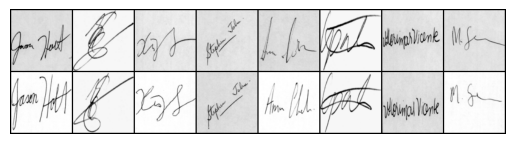

[0. 1. 0. 1. 0. 1. 1. 0.]


In [25]:
# Create a dataloader just visualization
vis_dataloader = DataLoader(forgery_train_dataset,
                        shuffle=True,
                        num_workers=2,
                        batch_size=8)

# Extract one batch
example_batch = next(iter(vis_dataloader))

# If the label is 1, it means that it is not the same person, label is 0, same person in both images
concatenated = torch.cat((example_batch[0], example_batch[1]),0)

imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy().reshape(-1))

##### Face Dataset<a class="anchor" id="1b">

In [26]:
class SiameseDataset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.dataset = subset.dataset
        self.indices = subset.indices
        self.transform = transform
        
    def __getitem__(self, index):
        index = self.indices[index]
        img0_tuple = self.dataset.imgs[index]

        should_get_same_class = random.randint(0, 1)
        if should_get_same_class:
            while True:
                img1_index = random.choice(self.indices)
                img1_tuple = self.dataset.imgs[img1_index]
                if img0_tuple[1] == img1_tuple[1]:
                    break
        else:
            while True:
                img1_index = random.choice(self.indices)
                img1_tuple = self.dataset.imgs[img1_index]
                if img0_tuple[1] != img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])

        img0 = img0.convert("L")
        img1 = img1.convert("L")

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1, torch.from_numpy(np.array([int(img1_tuple[1] != img0_tuple[1])], dtype=np.float32))
    
    def __len__(self):
        return len(self.indices)

In [27]:
# Define Dataset Folder
face_folder_dataset = datasets.ImageFolder(root="./data/faces/")

# Split the dataset into train, validation, and test sets
train_size = int(0.8 * len(face_folder_dataset))
valid_size = int(0.1 * len(face_folder_dataset))
test_size = len(face_folder_dataset) - train_size - valid_size
face_train_dataset, face_valid_dataset, face_test_dataset = torch.utils.data.random_split(face_folder_dataset, [train_size, valid_size, test_size])

# Apply the transformations
face_train_dataset = SiameseDataset(subset=face_train_dataset, transform=train_transform)
face_valid_dataset = SiameseDataset(subset=face_valid_dataset, transform=valid_test_transform)
face_test_dataset = SiameseDataset(subset=face_test_dataset, transform=valid_test_transform)

print(f"Number of training samples: {len(face_train_dataset)}")
print(f"Number of validation samples: {len(face_valid_dataset)}")
print(f"Number of testing samples: {len(face_test_dataset)}")

Number of training samples: 320
Number of validation samples: 40
Number of testing samples: 40


In [28]:
# Define Dataset Folder
signature_folder_dataset = datasets.ImageFolder(root="./data/signature/full")

# Split the dataset into train, validation, and test sets
train_size = int(0.8 * len(signature_folder_dataset))
valid_size = int(0.1 * len(signature_folder_dataset))
test_size = len(signature_folder_dataset) - train_size - valid_size
signature_train_dataset, signature_valid_dataset, signature_test_dataset = torch.utils.data.random_split(signature_folder_dataset, [train_size, valid_size, test_size])

# Apply the transformations
signature_train_dataset = SiameseDataset(subset=signature_train_dataset, transform=train_transform)
signature_valid_dataset = SiameseDataset(subset=signature_valid_dataset, transform=valid_test_transform)
signature_test_dataset = SiameseDataset(subset=signature_test_dataset, transform=valid_test_transform)

print(f"Number of training samples: {len(signature_train_dataset)}")
print(f"Number of validation samples: {len(signature_valid_dataset)}")
print(f"Number of testing samples: {len(signature_test_dataset)}")

Number of training samples: 3431
Number of validation samples: 428
Number of testing samples: 430


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.94509804..0.81960785].


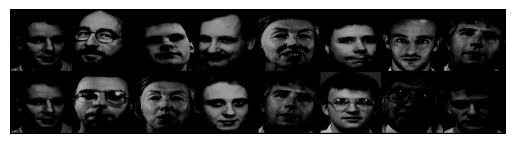

[0. 1. 1. 1. 1. 1. 1. 1.]


In [29]:
# Create a dataloader just visualization
vis_dataloader = DataLoader(face_test_dataset,
                        shuffle=True,
                        num_workers=2,
                        batch_size=8)

# Extract one batch
example_batch = next(iter(vis_dataloader))

# If the label is 1, it means that it is not the same person, label is 0, same person in both images
concatenated = torch.cat((example_batch[0], example_batch[1]),0)

imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy().reshape(-1))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.79607844..1.0].


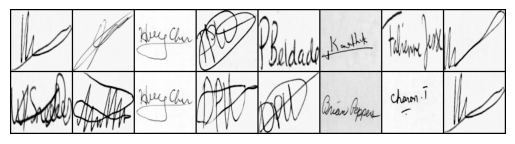

[1. 1. 0. 0. 1. 1. 1. 0.]


In [30]:
# Create a simple dataloader just for simple visualization
vis_dataloader = DataLoader(signature_test_dataset,
                        shuffle=True,
                        num_workers=2,
                        batch_size=8)

# Extract one batch
example_batch = next(iter(vis_dataloader))

# Example batch is a list containing 2x8 images, indexes 0 and 1, an also the label
# If the label is 1, it means that it is not the same person, label is 0, same person in both images
concatenated = torch.cat((example_batch[0], example_batch[1]),0)

imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy().reshape(-1))

[Back to the top](#0) 

## Define Model<a class="anchor" id="2">

In [4]:
# Define the Contrastive Loss Function
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=5.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
      # Calculate the euclidean distance and calculate the contrastive loss
      euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
      # label = 1 means different people, label = 0 means same people  
      loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                    (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


      return loss_contrastive

In [ ]:
import SiameseNetwork
# Load the training dataset
face_train_loader = DataLoader(face_train_dataset, shuffle=True, num_workers=8, batch_size=256)
face_valid_loader = DataLoader(face_valid_dataset, shuffle=True, num_workers=8, batch_size=256)

face_net = SiameseNetwork.SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(face_net.parameters(), lr = 0.00001)
face_net.train_network(train_loader = face_train_loader, val_loader = face_valid_loader, net = face_net, optimizer = optimizer, criterion = criterion, epochs = 100, patience=15)

checkpoint = {'model_state_dict': face_net.state_dict(),'optimizer_state_dict' :optimizer.state_dict()}
torch.save(checkpoint, './checkpoints/face_net.pt')
print('saved model checkpoint')

In [ ]:
signature_train_loader = DataLoader(signature_train_dataset, shuffle=True, num_workers=8, batch_size=128)
signature_valid_loader = DataLoader(signature_valid_dataset, shuffle=True, num_workers=8, batch_size=128)

signature_net = SiameseNetwork.SiameseNetwork().cuda()
criterion = ContrastiveLoss()

optimizer = optim.Adam(signature_net.parameters(), lr = 0.00001)
signature_net.train_network(signature_train_loader, signature_valid_loader, signature_net, optimizer, criterion, epochs=100, patience=15)


checkpoint = {'model_state_dict': signature_net.state_dict(),'optimizer_state_dict' :optimizer.state_dict()}
torch.save(checkpoint, './checkpoints/signature_net.pt')
print('saved model checkpoint')

In [7]:
import ForgeryNetwork

# Load the training dataset
forgery_train_loader = DataLoader(forgery_train_dataset, shuffle=True, num_workers=8, batch_size=8)
forgery_valid_loader = DataLoader(forgery_valid_dataset, shuffle=True, num_workers=8, batch_size=8)

forgery_net = ForgeryNetwork.ForgeryNetwork().cuda()

criterion = ContrastiveLoss()
optimizer = torch.optim.SGD(forgery_net.parameters(), lr=1e-3, weight_decay=0.005)
forgery_net.train_network(train_loader = forgery_train_loader, val_loader = forgery_valid_loader, net = forgery_net, optimizer = optimizer, criterion = criterion, epochs = 100, patience=15)

checkpoint = {'model_state_dict': face_net.state_dict(),'optimizer_state_dict' :optimizer.state_dict()}
torch.save(checkpoint, './checkpoints/forgery_net.pt')
print('saved model checkpoint')

Epoch number 0
 Current loss 17.194486618041992

Validation loss after 10 iterations: 12.50157881006757

Epoch number 0
 Current loss 12.499950408935547

Validation loss after 20 iterations: 12.49017969104681

Epoch number 0
 Current loss 18.74992561340332

Validation loss after 30 iterations: 12.490179688562094

Epoch number 0
 Current loss 15.624938011169434

Validation loss after 40 iterations: 12.501578816528312

Epoch number 0
 Current loss 9.37496280670166

Validation loss after 50 iterations: 12.490179687567904

Epoch number 0
 Current loss 12.499950408935547

Validation loss after 60 iterations: 12.490179691047018

Epoch number 0
 Current loss 15.624938011169434

Validation loss after 70 iterations: 12.490179691170946

Epoch number 0
 Current loss 6.249975204467773

Validation loss after 80 iterations: 12.501578805843167

Epoch number 0
 Current loss 6.249975204467773



KeyboardInterrupt: 

In [35]:
import SiameseNetwork

face_net = SiameseNetwork.SiameseNetwork().cuda()
face_model_path = f"./checkpoints/face_net.pt"
face_state_dict = torch.load(face_model_path)
face_net.load_state_dict(face_state_dict['model_state_dict'])

signature_net = SiameseNetwork.SiameseNetwork().cuda()
signature_model_path = f"./checkpoints/signature_net.pt"
signature_state_dict = torch.load(face_model_path)
signature_net.load_state_dict(signature_state_dict['model_state_dict'])

/home/fabian/DeepVisionProject/environment/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/fabian/DeepVisionProject/environment/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9137255..0.92941177].


face distance tensor([0.4134], device='cuda:0', grad_fn=<NormBackward1>); label tensor([[0.]])


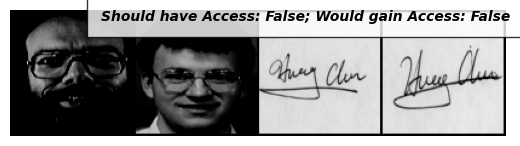

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9137255..0.96862745].


face distance tensor([0.3522], device='cuda:0', grad_fn=<NormBackward1>); label tensor([[0.]])


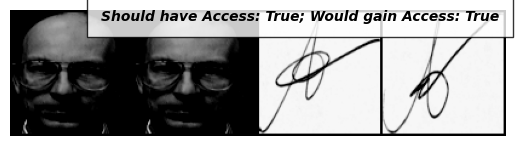

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.90588236..0.9843137].


face distance tensor([1.4142e-06], device='cuda:0', grad_fn=<NormBackward1>); label tensor([[0.]])


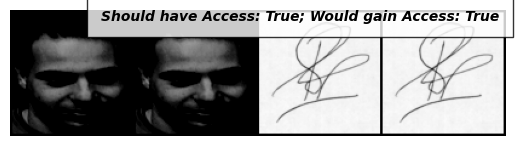

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9843137..0.96862745].


face distance tensor([1.4142e-06], device='cuda:0', grad_fn=<NormBackward1>); label tensor([[0.]])


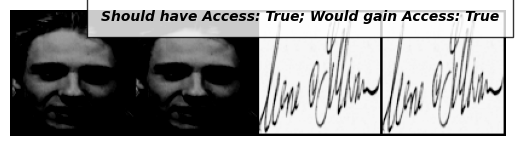

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8509804..0.96862745].


face distance tensor([0.8790], device='cuda:0', grad_fn=<NormBackward1>); label tensor([[0.]])


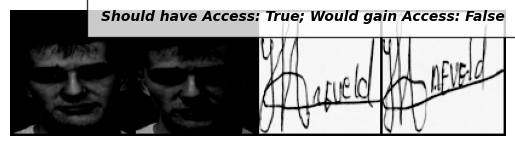

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.88235295..1.0].


face distance tensor([1.4142e-06], device='cuda:0', grad_fn=<NormBackward1>); label tensor([[0.]])


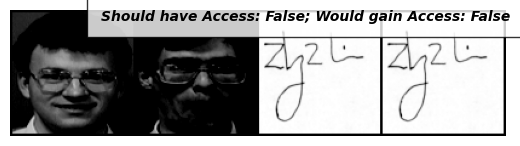

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7254902..0.96862745].


face distance tensor([0.4847], device='cuda:0', grad_fn=<NormBackward1>); label tensor([[1.]])


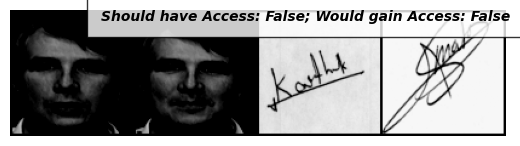

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9137255..0.92941177].


face distance tensor([0.2369], device='cuda:0', grad_fn=<NormBackward1>); label tensor([[0.]])


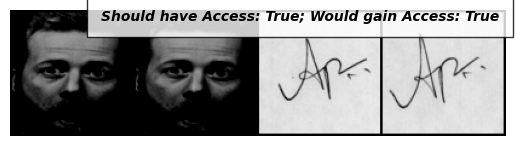

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.88235295..0.96862745].


face distance tensor([0.4415], device='cuda:0', grad_fn=<NormBackward1>); label tensor([[1.]])


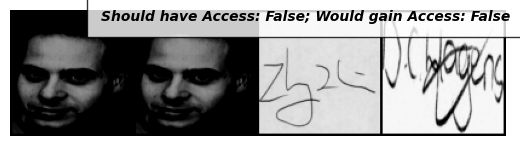

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.827451..0.92156863].


face distance tensor([0.7019], device='cuda:0', grad_fn=<NormBackward1>); label tensor([[1.]])


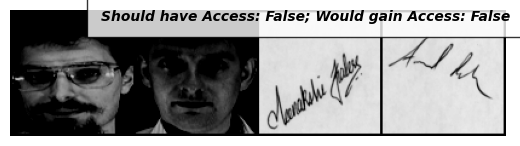

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.84313726..0.96862745].


face distance tensor([1.3490], device='cuda:0', grad_fn=<NormBackward1>); label tensor([[0.]])


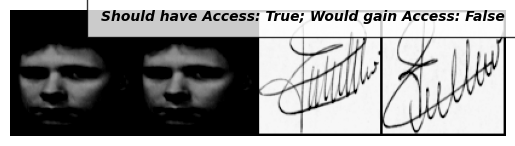

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9843137..0.99215686].


face distance tensor([0.4493], device='cuda:0', grad_fn=<NormBackward1>); label tensor([[0.]])


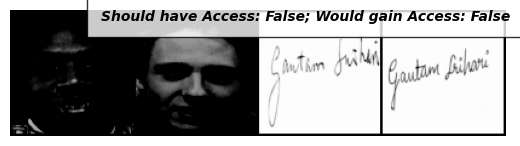

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9529412..0.96862745].


face distance tensor([1.6894], device='cuda:0', grad_fn=<NormBackward1>); label tensor([[1.]])


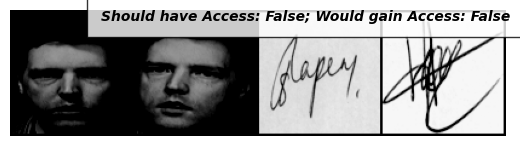

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9607843..0.96862745].


face distance tensor([1.5650], device='cuda:0', grad_fn=<NormBackward1>); label tensor([[1.]])


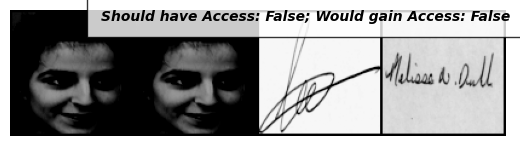

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9529412..1.0].


face distance tensor([0.8382], device='cuda:0', grad_fn=<NormBackward1>); label tensor([[1.]])


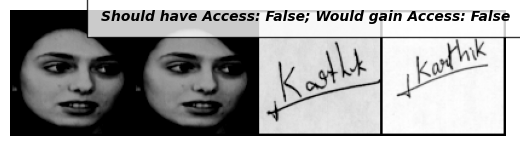

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.92941177..1.0].


face distance tensor([0.1767], device='cuda:0', grad_fn=<NormBackward1>); label tensor([[1.]])


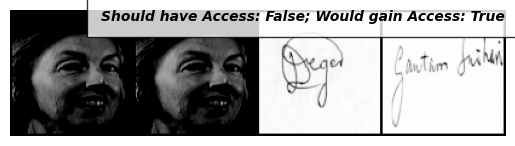

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9843137..1.0].


face distance tensor([0.8718], device='cuda:0', grad_fn=<NormBackward1>); label tensor([[1.]])


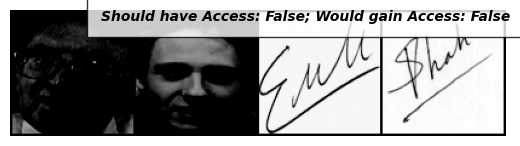

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8745098..1.0].


face distance tensor([0.5999], device='cuda:0', grad_fn=<NormBackward1>); label tensor([[1.]])


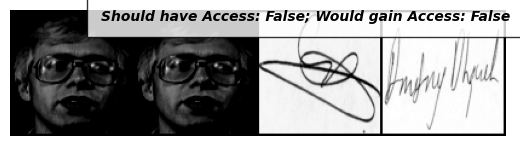

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.94509804..0.94509804].


face distance tensor([0.4751], device='cuda:0', grad_fn=<NormBackward1>); label tensor([[0.]])


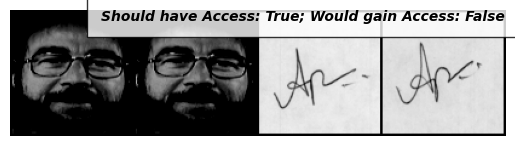

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9137255..0.96862745].


face distance tensor([1.0838], device='cuda:0', grad_fn=<NormBackward1>); label tensor([[0.]])


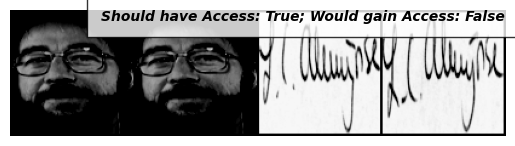

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9137255..0.96862745].


face distance tensor([0.0726], device='cuda:0', grad_fn=<NormBackward1>); label tensor([[1.]])


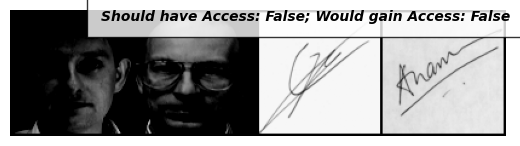

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9137255..0.92156863].


face distance tensor([1.4142e-06], device='cuda:0', grad_fn=<NormBackward1>); label tensor([[0.]])


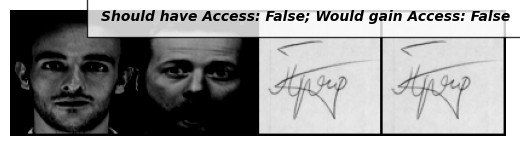

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8509804..1.0].


face distance tensor([0.6555], device='cuda:0', grad_fn=<NormBackward1>); label tensor([[1.]])


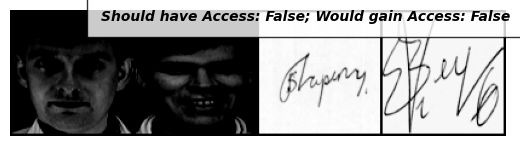

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.96862745..0.99215686].


face distance tensor([1.4142e-06], device='cuda:0', grad_fn=<NormBackward1>); label tensor([[0.]])


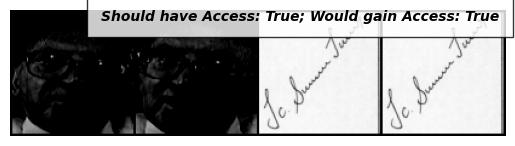

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8666667..0.96862745].


face distance tensor([0.7858], device='cuda:0', grad_fn=<NormBackward1>); label tensor([[0.]])


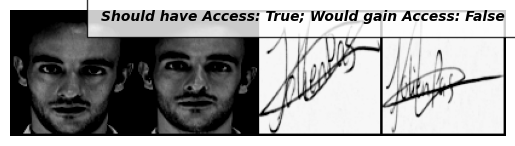

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.84313726..1.0].


face distance tensor([1.3654], device='cuda:0', grad_fn=<NormBackward1>); label tensor([[1.]])


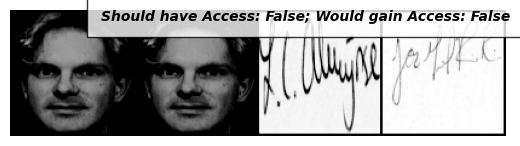

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9607843..0.96862745].


face distance tensor([1.4142e-06], device='cuda:0', grad_fn=<NormBackward1>); label tensor([[0.]])


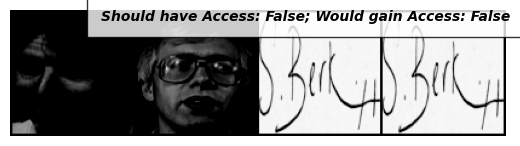

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.85882354..1.0].


face distance tensor([1.0418], device='cuda:0', grad_fn=<NormBackward1>); label tensor([[1.]])


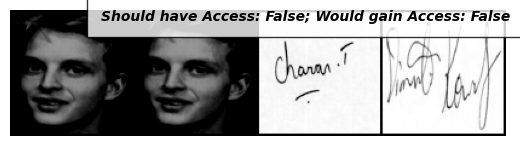

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8509804..1.0].


face distance tensor([1.2712], device='cuda:0', grad_fn=<NormBackward1>); label tensor([[1.]])


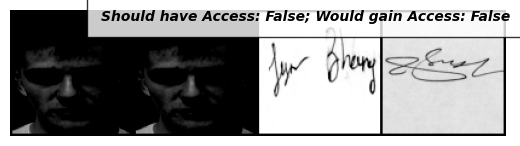

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.90588236..0.96862745].


face distance tensor([1.4142e-06], device='cuda:0', grad_fn=<NormBackward1>); label tensor([[0.]])


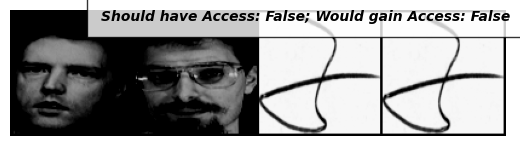

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.92156863..1.0].


face distance tensor([1.1176], device='cuda:0', grad_fn=<NormBackward1>); label tensor([[1.]])


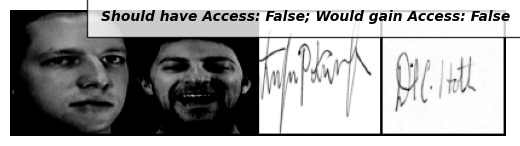

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8666667..0.96862745].


face distance tensor([0.3024], device='cuda:0', grad_fn=<NormBackward1>); label tensor([[0.]])


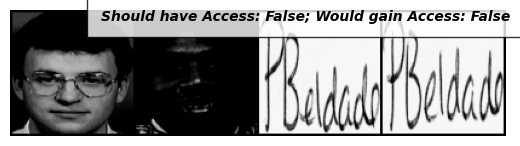

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9529412..0.96862745].


face distance tensor([1.4142e-06], device='cuda:0', grad_fn=<NormBackward1>); label tensor([[0.]])


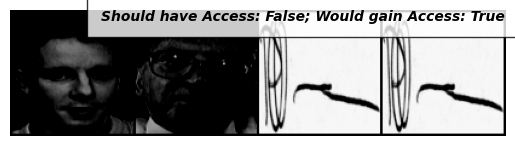

face distance tensor([1.4744], device='cuda:0', grad_fn=<NormBackward1>); label tensor([[0.]])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8666667..1.0].


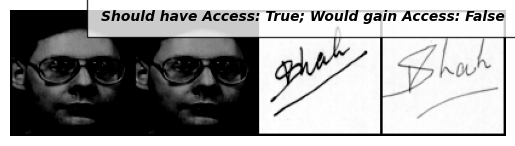

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9372549..0.96862745].


face distance tensor([1.0781], device='cuda:0', grad_fn=<NormBackward1>); label tensor([[1.]])


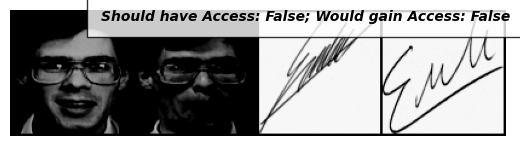

face distance tensor([1.8375], device='cuda:0', grad_fn=<NormBackward1>); label tensor([[1.]])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8509804..0.96862745].


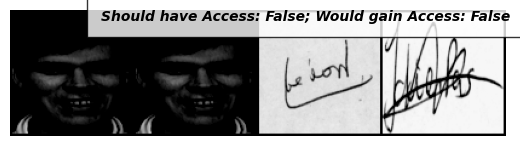

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.92156863..0.92941177].


face distance tensor([1.4142e-06], device='cuda:0', grad_fn=<NormBackward1>); label tensor([[0.]])


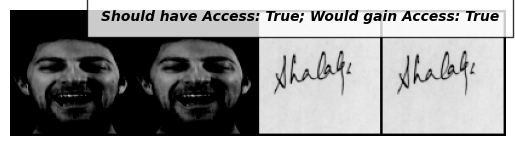

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.88235295..0.96862745].


face distance tensor([1.4142e-06], device='cuda:0', grad_fn=<NormBackward1>); label tensor([[0.]])


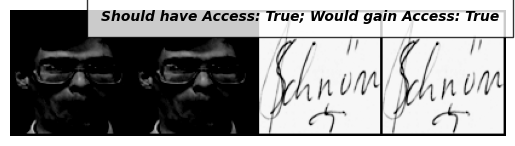

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7254902..0.96862745].


face distance tensor([1.4142e-06], device='cuda:0', grad_fn=<NormBackward1>); label tensor([[0.]])


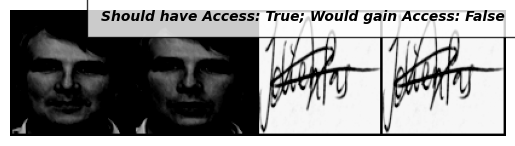

face distance tensor([0.6220], device='cuda:0', grad_fn=<NormBackward1>); label tensor([[0.]])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.88235295..1.0].


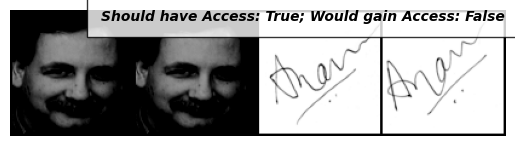

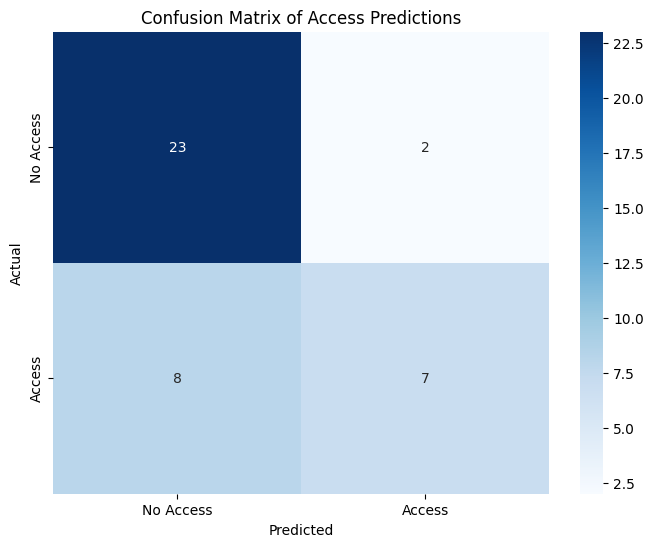

In [37]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
# Locate the test dataset and load it into the SiameseNetworkDataset
face_net.eval()
signature_net.eval()

face_test_dataloader = DataLoader(face_test_dataset, num_workers=2, batch_size=1, shuffle=True)
signature_test_loader = DataLoader(signature_test_dataset, shuffle=True, num_workers=2, batch_size=1)

# Grab one image that we are going to test
face_dataiter = iter(face_test_dataloader)
signature_dataiter = iter(signature_test_loader)

should_have_access_list = []
would_gain_access_list = []

for i in range(len(face_test_dataloader)):
    # Iterate over 5 images and test them with the first image (x0)
    face0, face1, face_label = next(face_dataiter)
    signature1, signature2, forge_label = next(signature_dataiter)

    face_output1, face_output2 = face_net(face0.cuda(), face1.cuda())
    euclidean_distance = F.pairwise_distance(face_output1, face_output2)
    #print(f"face distance {euclidean_distance}; label {face_label}")
    face_distance = (euclidean_distance < 1.5).bool()

    signature_output1, signature_output2 = signature_net(signature1.cuda(), signature2.cuda())
    #print(torch.sigmoid(forgery_output).bool())
    euclidean_distance = F.pairwise_distance(signature_output1, signature_output2)
    print(f"face distance {euclidean_distance}; label {forge_label}")

    signature_distance = (euclidean_distance < 0.4).bool()
    
    # Concatenate the two images together
    concatenated = torch.cat((face0, face1, signature1, signature2), 0)
    would_gain_access = face_distance.cpu()[0] and signature_distance.cpu()[0]
    should_have_access = not face_label.cpu()[0][0].bool() and not forge_label.cpu()[0][0].bool() 
    should_have_access_list.append(should_have_access)
    would_gain_access_list.append(would_gain_access)
    
    imshow(torchvision.utils.make_grid(concatenated), f'Should have Access: {should_have_access}; Would gain Access: {would_gain_access}')


# Create confusion matrix
conf_matrix = confusion_matrix(should_have_access_list, would_gain_access_list)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Access', 'Access'], yticklabels=['No Access', 'Access'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of Access Predictions')
plt.show()